### 도로 특성을 반영한 클러스터링

#### 지리학과 석사3기 이용채

#### 0. Setting

In [5]:
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np
import geopandas as gpd

from geopy.distance import geodesic

from sklearn.metrics.pairwise import cosine_similarity

import os


#### 1. Creat a graph & Carculate node attributes

In [15]:
# 그래프 추출을 위한 주소 설정
adr = '동대문구, 서울시, 대한민국'

# 장소를 기반으로 그래프 추출
G = ox.graph_from_place(adr, network_type='all', custom_filter='["highway"~"residential|living_street|service|pedestrian"]')

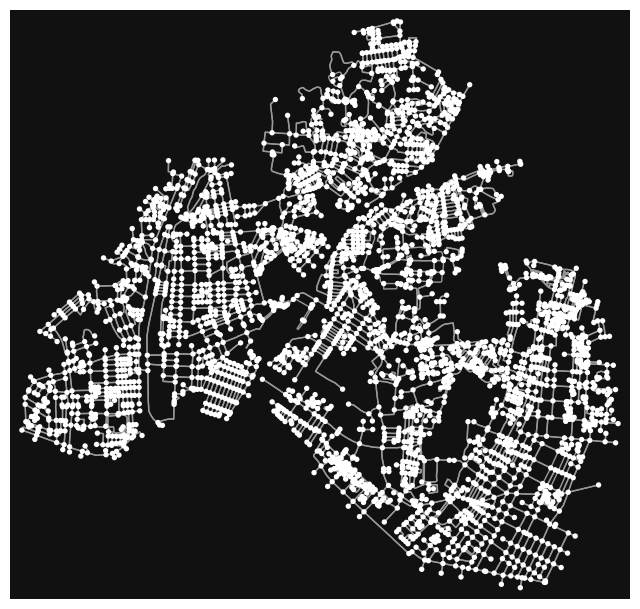

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [16]:
ox.plot_graph(G)

C:\Users\Yeorim\AppData\Local\Temp\ipykernel_5804\973323582.py:2: FutureWarning: The `get_undirected` function is deprecated and will be removed in the v2.0.0 release. Replace it with `convert.to_undirected` instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  GG = ox.add_edge_bearings(ox.get_undirected(G))
d:\anaconda_envs\pynkdv\lib\site-packages\osmnx\convert.py:381: FutureWarning: <class 'geopandas.array.GeometryArray'>._reduce will require a `keepdims` parameter in the future
  dupes = edges[mask].dropna(subset=["geometry"])


(<Figure size 500x500 with 1 Axes>,
 <PolarAxes: title={'center': 'Dongdaemun-gu'}>)

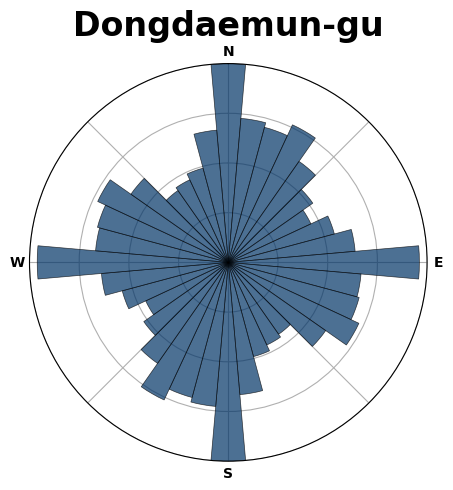

In [18]:
# 엣지 bearings 계산
GG = ox.add_edge_bearings(ox.get_undirected(G))

# 그래프 방향성 시각화
ox.plot_orientation(GG, title="Dongdaemun-gu", area=True)

In [19]:
# 엣지 우회도 평균
print(ox.stats.circuity_avg(GG))

# 엣지별 우회도 계산 (네트워크 거리 / 직선거리)
for u, v, key, data in GG.edges(keys=True, data=True):
    length = data.get('length', 0) # 엣지 속성의 length가 네트워크 거리

    x1 = GG.nodes[u]['x']
    y1 = GG.nodes[u]['y']
    x2 = GG.nodes[v]['x']
    y2 = GG.nodes[v]['y']

    straight_distance = geodesic((y1, x1), (y2, x2)).meters # 직선거리 (경위도 좌표 사용)

    if straight_distance > 0:
            circuity = length / straight_distance
    else:
            circuity = 0

    data['circuity'] = circuity

1.0611018120848552


In [20]:
# 노드, 엣지 정보 geodataframe으로 추출
nodes, edges = ox.graph_to_gdfs(
        GG,
        nodes=True, edges=True,
        node_geometry=True,
        fill_edge_geometry=True)

In [21]:
# 라인 그래프 변환 후 노드(원래 그래프의 엣지)의 중심성 계산
edge_centrality = nx.closeness_centrality(nx.line_graph(GG))

# 계산한 중심성을 다시 그래프의 엣지 속성에 적용
nx.set_edge_attributes(GG, edge_centrality, 'edge_centrality')

In [22]:
edges.head()

osmid  \
u         v           key                                      
287710021 7068765358  0                           1339878025   
          3830520095  0                            379724405   
          3830520000  0    [416569032, 416569034, 416569036]   
287710035 11170069502 0                           1205266037   
414685964 10215049897 0                            379724157   

                                       name      highway  oneway  \
u         v           key                                          
287710021 7068765358  0              왕산로40길  residential   False   
          3830520095  0                 NaN      service    True   
          3830520000  0    [답십리로1길, 왕산로40길]  residential   False   
287710035 11170069502 0              왕산로40길  residential   False   
414685964 10215049897 0             답십리로15길  residential   False   

                                reversed   length       from           to  \
u         v           key                                                   
287710021 7068765358  0             True    4.969  287710021   7068765358   
          3830520095  0            False  121.634  287710021   3830520095   
          3830520000  0    [False, True]  184.797  287710021   3830520000   
287710035 11170069502 0            False   13.563  287710035  11170069502   
414685964 10215049897 0            False   64.422  414685964  10215049897   

                                                                    geometry  \
u         v           key                                                      
287710021 7068765358  0    LINESTRING (127.04520 37.57999, 127.04522 37.5...   
          3830520095  0    LINESTRING (127.04522 37.57995, 127.04536 37.5...   
          3830520000  0    LINESTRING (127.04383 37.57908, 127.04472 37.5...   
287710035 11170069502 0    LINESTRING (127.04513 37.58004, 127.04501 37.5...   
414685964 10215049897 0    LINESTRING (127.04646 37.57720, 127.04602 37.5...   

                           bearing  circuity access lanes maxspeed service  \
u         v           key                                                    
287710021 7068765358  0      335.9  1.001171    NaN   NaN      NaN     NaN   
          3830520095  0       48.5  1.037732     no   NaN      NaN     NaN   
          3830520000  0      231.8  1.183419    NaN     2      NaN     NaN   
287710035 11170069502 0      130.1  0.999359    NaN   NaN      NaN     NaN   
414685964 10215049897 0       55.2  1.001326    NaN   NaN      NaN     NaN   

                          tunnel junction bridge width area  
u         v           key                                    
287710021 7068765358  0      NaN      NaN    NaN   NaN  NaN  
          3830520095  0      NaN      NaN    NaN   NaN  NaN  
          3830520000  0      NaN      NaN    NaN   NaN  NaN  
287710035 11170069502 0      NaN      NaN    NaN   NaN  NaN  
414685964 10215049897 0      NaN      NaN    NaN   NaN  NaN

In [23]:
# networkx의 line_graph를 사용하여 변환
# 라인 그래프 변환 시 원래 그래프의 엣지 속성과 좌표, 투영 정보가 자동으로 복사되지 않음
line_GG = nx.line_graph(GG)

In [24]:
line_GG.nodes # 속성은 복사되지 않음

NodeView(((287710035, 11170069502, 0), (414685964, 10215049897, 0), (414685979, 9932120787, 0), (436718791, 3252764030, 0), (436718795, 3830519879, 0), (436718803, 3830520000, 0), (436718837, 4173391975, 0), (436776271, 3369302134, 0), (436818258, 3828715753, 0), (436833479, 3785302855, 0), (436833497, 8327193044, 0), (436833499, 3830519431, 0), (436833500, 3830519430, 0), (436833505, 10215050015, 0), (436833512, 11813171096, 0), (436844927, 3830519858, 0), (436849755, 3832322014, 0), (436849764, 3831374493, 0), (436866826, 3828715951, 0), (436868085, 3372133681, 0), (436870322, 3800707917, 0), (436870330, 3832416071, 0), (436870863, 3832605496, 0), (436870866, 4174560615, 0), (436870874, 3830520114, 0), (436870880, 3830520379, 0), (436870888, 3830519444, 0), (436871814, 436871817, 0), (436875635, 8508478950, 0), (436880333, 3832271008, 0), (436881851, 3830520209, 0), (436881875, 3830680126, 0), (436881877, 3830680173, 0), (436881885, 3828715944, 0), (436881887, 3828715949, 0), (436882

In [25]:
# 라인 그래프의 노드 좌표 정보 삽입 (투영 위해서 좌표 정보 필요)
for node in line_GG.nodes():
    u, v, key = node
    
    x1, y1 = GG.nodes[u]['x'], GG.nodes[u]['y'] # 원래 그래프의 from, to 노드의 좌표의 중심점 계산
    x2, y2 = GG.nodes[v]['x'], GG.nodes[v]['y']
    
    mid_x = (x1 + x2) / 2
    mid_y = (y1 + y2) / 2
    
    line_GG.nodes[node]['x'] = mid_x
    line_GG.nodes[node]['y'] = mid_y

In [26]:
print(GG.graph['crs'])

line_GG.graph['crs'] = edges.crs

epsg:4326


In [27]:
# 원래 그래프의 엣지 속성을 라인 그래프의 노드 속성으로 복사
line_GG.add_nodes_from((node, GG.edges[node]) for node in line_GG)

In [28]:
# 멀티 인덱스를 단일 인덱스로 변환
mapping = {node: f"{node[0]}_{node[1]}_{node[2]}" for node in line_GG.nodes}
line_GG = nx.relabel_nodes(line_GG, mapping)

In [29]:
# 추가해준 정보를 이용하여 투영
line_GG = ox.project_graph(line_GG, to_crs='EPSG:4326')

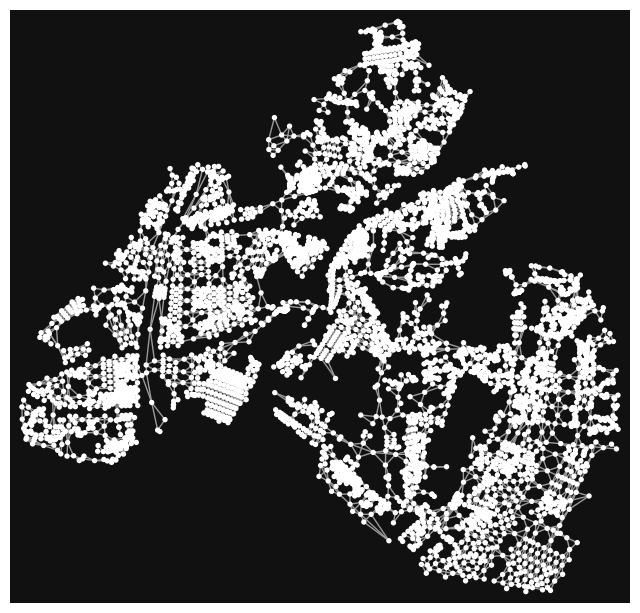

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [30]:
ox.plot_graph(line_GG)

In [31]:
# 라인 그래프 정보 추출
line_nodes, line_edges = ox.graph_to_gdfs(
        line_GG,
        nodes=True, edges=True,
        node_geometry=True,
        fill_edge_geometry=True)

In [32]:
# 라인 그래프의 노드 정보 geodataframe
line_nodes.head()

,x,y,osmid,name,highway,oneway,reversed,length,from,to,...,access,service,lanes,maxspeed,tunnel,bridge,area,junction,width,geometry
osmid,,,,,,,,,,,,,,,,,,,,,
287710035_11170069502_0,127.045066,37.580080,1205266037,왕산로40길,residential,False,False,13.563,287710035,11170069502,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (127.04507 37.58008)
5194866087_11170069502_0,127.045686,37.580414,768490146,NaN,service,True,False,130.559,5194866087,11170069502,...,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (127.04569 37.58041)
7068765358_11170069502_0,127.045161,37.580016,1339878024,왕산로40길,residential,False,True,8.435,7068765358,11170069502,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (127.04516 37.58002)
414685964_10215049897_0,127.046165,37.577040,379724157,답십리로15길,residential,False,False,64.422,414685964,10215049897,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (127.04616 37.57704)
10215049895_10215049897_0,127.046603,37.577273,379724157,답십리로15길,residential,False,True,28.804,10215049895,10215049897,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (127.04660 37.57727)


In [33]:
# 원래 그래프의 엣지 정보 geodataframe
edges.head()

osmid  \
u         v           key                                      
287710021 7068765358  0                           1339878025   
          3830520095  0                            379724405   
          3830520000  0    [416569032, 416569034, 416569036]   
287710035 11170069502 0                           1205266037   
414685964 10215049897 0                            379724157   

                                       name      highway  oneway  \
u         v           key                                          
287710021 7068765358  0              왕산로40길  residential   False   
          3830520095  0                 NaN      service    True   
          3830520000  0    [답십리로1길, 왕산로40길]  residential   False   
287710035 11170069502 0              왕산로40길  residential   False   
414685964 10215049897 0             답십리로15길  residential   False   

                                reversed   length       from           to  \
u         v           key                                                   
287710021 7068765358  0             True    4.969  287710021   7068765358   
          3830520095  0            False  121.634  287710021   3830520095   
          3830520000  0    [False, True]  184.797  287710021   3830520000   
287710035 11170069502 0            False   13.563  287710035  11170069502   
414685964 10215049897 0            False   64.422  414685964  10215049897   

                                                                    geometry  \
u         v           key                                                      
287710021 7068765358  0    LINESTRING (127.04520 37.57999, 127.04522 37.5...   
          3830520095  0    LINESTRING (127.04522 37.57995, 127.04536 37.5...   
          3830520000  0    LINESTRING (127.04383 37.57908, 127.04472 37.5...   
287710035 11170069502 0    LINESTRING (127.04513 37.58004, 127.04501 37.5...   
414685964 10215049897 0    LINESTRING (127.04646 37.57720, 127.04602 37.5...   

                           bearing  circuity access lanes maxspeed service  \
u         v           key                                                    
287710021 7068765358  0      335.9  1.001171    NaN   NaN      NaN     NaN   
          3830520095  0       48.5  1.037732     no   NaN      NaN     NaN   
          3830520000  0      231.8  1.183419    NaN     2      NaN     NaN   
287710035 11170069502 0      130.1  0.999359    NaN   NaN      NaN     NaN   
414685964 10215049897 0       55.2  1.001326    NaN   NaN      NaN     NaN   

                          tunnel junction bridge width area  
u         v           key                                    
287710021 7068765358  0      NaN      NaN    NaN   NaN  NaN  
          3830520095  0      NaN      NaN    NaN   NaN  NaN  
          3830520000  0      NaN      NaN    NaN   NaN  NaN  
287710035 11170069502 0      NaN      NaN    NaN   NaN  NaN  
414685964 10215049897 0      NaN      NaN    NaN   NaN  NaN

#### 2. Pytorch & PyG installation

In [32]:
!nvidia-smi

Wed Dec 18 12:06:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 ...  WDDM  |   00000000:08:00.0  On |                  N/A |
| 30%   33C    P0             40W /  125W |    1318MiB /   6144MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [13]:
!python -c "import torch; print(torch.__version__)"

^C


2.4.1


In [53]:
!python -c "import torch; print(torch.version.cuda)"

None


In [75]:
!pip install intel-openmp

   ---------------------------------------- 0.0/3.7 MB ? eta -:--:--
   ------------------------- -------------- 2.4/3.7 MB 12.3 MB/s eta 0:00:01
   ---------------------------------------- 3.7/3.7 MB 11.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 1.2/1.2 MB 9.7 MB/s eta 0:00:00


- https://pytorch.org/get-started/previous-versions/

In [47]:
%%cmd
# python -m pip uninstall torch torchvision torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -y
# python -m pip cache purge
# python -m pip install torch==1.7.1+cpu torchvision==0.8.2+cpu -f https://download.pytorch.org/whl/torch_stable.html
# python -m pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.1.html
# python -m pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.1.html
# python -m pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.1.html
# python -m pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.7.1.html
# python -m pip install torch-geometric
# python -c "import torch; import torch_geometric; print('Torch version:', torch.__version__); print('Torch Geometric version:', torch_geometric.__version__)"


Microsoft Windows [Version 10.0.22631.4602]
(c) Microsoft Corporation. All rights reserved.

(D:\anaconda_envs\pynkdv) z:\home\study\course work\3��\KHU_GEOG7013_Urban_Analytics\project># python -m pip uninstall torch torchvision torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -y


'#'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.



(D:\anaconda_envs\pynkdv) z:\home\study\course work\3��\KHU_GEOG7013_Urban_Analytics\project># python -m pip cache purge


'#'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.



(D:\anaconda_envs\pynkdv) z:\home\study\course work\3��\KHU_GEOG7013_Urban_Analytics\project>python -m pip install torch==1.7.1+cpu torchvision==0.8.2+cpu -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ------------------------------------- 184.2/184.2 MB 11.7 MB/s eta 0:00:00
     ------------------------------------- 804.8/804.8 kB 11.5 MB/s eta 0:00:00



(D:\anaconda_envs\pynkdv) z:\home\study\course work\3��\KHU_GEOG7013_Urban_Analytics\project># python -m pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.1.html


'#'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.



(D:\anaconda_envs\pynkdv) z:\home\study\course work\3��\KHU_GEOG7013_Urban_Analytics\project># python -m pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.1.html


'#'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.



(D:\anaconda_envs\pynkdv) z:\home\study\course work\3��\KHU_GEOG7013_Urban_Analytics\project># python -m pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.1.html


'#'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.



(D:\anaconda_envs\pynkdv) z:\home\study\course work\3��\KHU_GEOG7013_Urban_Analytics\project># python -m pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.7.1.html


'#'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.



(D:\anaconda_envs\pynkdv) z:\home\study\course work\3��\KHU_GEOG7013_Urban_Analytics\project># python -m pip install torch-geometric


'#'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.



(D:\anaconda_envs\pynkdv) z:\home\study\course work\3��\KHU_GEOG7013_Urban_Analytics\project># python -c "import torch; import torch_geometric; print('Torch version:', torch.__version__); print('Torch Geometric version:', torch_geometric.__version__)"


'#'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.



(D:\anaconda_envs\pynkdv) z:\home\study\course work\3��\KHU_GEOG7013_Urban_Analytics\project>

#### 3. Convert graph to PyG dataset

In [34]:
import torch
import torch_geometric
from torch_geometric.datasets import Planetoid
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import torch
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx

In [32]:
# 테스트 데이터
dataset = Planetoid(root='data/Planetoid', name='Cora')
data = dataset[0]

Processing...
Done!


In [43]:
print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [35]:
line_nodes.head()

,x,y,osmid,name,highway,oneway,reversed,length,from,to,...,access,service,lanes,maxspeed,tunnel,bridge,area,junction,width,geometry
osmid,,,,,,,,,,,,,,,,,,,,,
287710035_11170069502_0,127.045066,37.580080,1205266037,왕산로40길,residential,False,False,13.563,287710035,11170069502,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (127.04507 37.58008)
5194866087_11170069502_0,127.045686,37.580414,768490146,NaN,service,True,False,130.559,5194866087,11170069502,...,no,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (127.04569 37.58041)
7068765358_11170069502_0,127.045161,37.580016,1339878024,왕산로40길,residential,False,True,8.435,7068765358,11170069502,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (127.04516 37.58002)
414685964_10215049897_0,127.046165,37.577040,379724157,답십리로15길,residential,False,False,64.422,414685964,10215049897,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (127.04616 37.57704)
10215049895_10215049897_0,127.046603,37.577273,379724157,답십리로15길,residential,False,True,28.804,10215049895,10215049897,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (127.04660 37.57727)


In [36]:
line_edges.head()

geometry
u                        v                         key                                                   
287710035_11170069502_0  5194866087_11170069502_0  0    LINESTRING (127.04507 37.58008, 127.04569 37.5...
                         7068765358_11170069502_0  0    LINESTRING (127.04507 37.58008, 127.04516 37.5...
5194866087_11170069502_0 7068765358_11170069502_0  0    LINESTRING (127.04569 37.58041, 127.04516 37.5...
414685964_10215049897_0  10215049895_10215049897_0 0    LINESTRING (127.04616 37.57704, 127.04660 37.5...
                         10215049897_10215049902_0 0    LINESTRING (127.04616 37.57704, 127.04663 37.5...

In [37]:
line_nodes = line_nodes.fillna(0)

# 불필요한 속성 삭제
new_nodes = line_nodes.drop(['osmid',
                             'highway', 'oneway', 'name', 'reversed', 'maxspeed', 'from', 'to', 'bridge', 'access',
                             'lon','lat','service',
                             'tunnel', 'area', 'junction', 'width'], axis=1)

In [38]:
new_nodes.head()

,x,y,length,bearing,circuity,edge_centrality,lanes,geometry
osmid,,,,,,,,
287710035_11170069502_0,127.045066,37.580080,13.563,130.1,0.999359,0.023152,0,POINT (127.04507 37.58008)
5194866087_11170069502_0,127.045686,37.580414,130.559,230.0,1.011335,0.023446,0,POINT (127.04569 37.58041)
7068765358_11170069502_0,127.045161,37.580016,8.435,311.0,0.999484,0.023401,0,POINT (127.04516 37.58002)
414685964_10215049897_0,127.046165,37.577040,64.422,55.2,1.001326,0.017466,0,POINT (127.04616 37.57704)
10215049895_10215049897_0,127.046603,37.577273,28.804,238.1,0.998811,0.017777,0,POINT (127.04660 37.57727)


In [39]:
# 필요 없는 속성 제거한 그래프 생성
new_graph = ox.graph_from_gdfs(new_nodes, line_edges)

In [40]:
new_graph.nodes(data=True)

NodeDataView({'287710035_11170069502_0': {'x': 127.04506635, 'y': 37.5800802, 'length': 13.563, 'bearing': 130.1, 'circuity': 0.9993585681426941, 'edge_centrality': 0.023152183493785932, 'lanes': 0}, '5194866087_11170069502_0': {'x': 127.04568565, 'y': 37.5804141, 'length': 130.559, 'bearing': 230.0, 'circuity': 1.0113352372154119, 'edge_centrality': 0.02344575194513456, 'lanes': 0}, '7068765358_11170069502_0': {'x': 127.0451613, 'y': 37.580016, 'length': 8.435, 'bearing': 311.0, 'circuity': 0.9994837037333549, 'edge_centrality': 0.02340095920175408, 'lanes': 0}, '414685964_10215049897_0': {'x': 127.04616475, 'y': 37.57703955, 'length': 64.422, 'bearing': 55.2, 'circuity': 1.0013262493284234, 'edge_centrality': 0.017466474565000552, 'lanes': 0}, '10215049895_10215049897_0': {'x': 127.04660279999999, 'y': 37.5772731, 'length': 28.804, 'bearing': 238.1, 'circuity': 0.9988109829220861, 'edge_centrality': 0.01777664146303865, 'lanes': 0}, '10215049897_10215049902_0': {'x': 127.046625049999

In [41]:
node_list = list(new_graph.nodes)

# 노드 정보
print(len(node_list))
print(node_list)

4729
['287710035_11170069502_0', '5194866087_11170069502_0', '7068765358_11170069502_0', '414685964_10215049897_0', '10215049895_10215049897_0', '10215049897_10215049902_0', '3830519869_10215049895_0', '414685979_9932120787_0', '3831374593_9932120787_0', '9932120787_9932120789_0', '436718791_3252764030_0', '3252764030_3252764043_0', '3252764030_3252764873_0', '3252764030_3252764038_0', '3252764043_3252764872_0', '3252764027_3252764043_0', '3252764034_3252764038_0', '436718795_3830519879_0', '3830519849_3830519879_0', '3830519876_3830519879_0', '3830519849_3830519863_0', '436718803_3830520000_0', '3097356121_3830520000_0', '287710021_3830520000_0', '3830519940_3830520000_0', '287710021_7068765358_0', '287710021_3830520095_0', '3830519928_3830519940_0', '436718837_4173391975_0', '2246875387_4173391975_0', '3830680042_4173391975_0', '3830680129_4173391975_0', '3830680042_3830680062_0', '3830680034_3830680042_0', '436776271_3369302134_0', '3369302116_3369302134_0', '3369302115_3369302134_0

In [42]:
# 노드 인덱스 리셋
node_id_map = {node: idx for idx, node in enumerate(node_list)}

node_id_map

{'287710035_11170069502_0': 0,
 '5194866087_11170069502_0': 1,
 '7068765358_11170069502_0': 2,
 '414685964_10215049897_0': 3,
 '10215049895_10215049897_0': 4,
 '10215049897_10215049902_0': 5,
 '3830519869_10215049895_0': 6,
 '414685979_9932120787_0': 7,
 '3831374593_9932120787_0': 8,
 '9932120787_9932120789_0': 9,
 '436718791_3252764030_0': 10,
 '3252764030_3252764043_0': 11,
 '3252764030_3252764873_0': 12,
 '3252764030_3252764038_0': 13,
 '3252764043_3252764872_0': 14,
 '3252764027_3252764043_0': 15,
 '3252764034_3252764038_0': 16,
 '436718795_3830519879_0': 17,
 '3830519849_3830519879_0': 18,
 '3830519876_3830519879_0': 19,
 '3830519849_3830519863_0': 20,
 '436718803_3830520000_0': 21,
 '3097356121_3830520000_0': 22,
 '287710021_3830520000_0': 23,
 '3830519940_3830520000_0': 24,
 '287710021_7068765358_0': 25,
 '287710021_3830520095_0': 26,
 '3830519928_3830519940_0': 27,
 '436718837_4173391975_0': 28,
 '2246875387_4173391975_0': 29,
 '3830680042_4173391975_0': 30,
 '3830680129_417339

In [43]:
new_edges = list(new_graph.edges)

# 엣지 인덱스도 리셋한 노드 인덱스와 매칭

node_indexed_edges = [
    (node_id_map[u], node_id_map[v])
    for u, v, key in new_edges
]

node_indexed_edges

[(0, 1),
 (0, 2),
 (1, 2),
 (3, 4),
 (3, 5),
 (4, 6),
 (5, 4),
 (7, 8),
 (7, 9),
 (9, 8),
 (10, 11),
 (10, 12),
 (10, 13),
 (11, 12),
 (11, 14),
 (11, 15),
 (11, 13),
 (12, 13),
 (13, 16),
 (14, 382),
 (15, 14),
 (15, 371),
 (15, 372),
 (16, 375),
 (17, 18),
 (17, 19),
 (18, 19),
 (18, 20),
 (20, 3489),
 (21, 22),
 (21, 23),
 (21, 24),
 (22, 24),
 (22, 23),
 (23, 25),
 (23, 24),
 (23, 26),
 (24, 27),
 (25, 2),
 (25, 26),
 (26, 3709),
 (28, 29),
 (28, 30),
 (28, 31),
 (29, 30),
 (29, 31),
 (30, 31),
 (30, 32),
 (30, 33),
 (33, 32),
 (34, 35),
 (34, 36),
 (35, 37),
 (35, 36),
 (35, 38),
 (36, 39),
 (37, 39),
 (38, 3316),
 (38, 37),
 (40, 41),
 (40, 42),
 (41, 43),
 (41, 44),
 (42, 41),
 (44, 43),
 (45, 46),
 (45, 47),
 (45, 48),
 (46, 47),
 (48, 47),
 (48, 46),
 (49, 50),
 (49, 51),
 (51, 52),
 (51, 53),
 (51, 50),
 (53, 52),
 (54, 55),
 (54, 56),
 (54, 57),
 (55, 57),
 (55, 56),
 (56, 58),
 (56, 57),
 (59, 60),
 (59, 58),
 (60, 61),
 (60, 58),
 (61, 52),
 (62, 63),
 (62, 64),
 (63, 64),

In [45]:
for node, data in new_graph.nodes(data=True):
    for key, value in data.items():
        data[key] = float(value)

In [46]:
# 노드 속성 추출하여 텐서로 변환
node_features = []
for node, data in new_graph.nodes(data=True):
    features = [data['length'], data['bearing'],
                data['circuity'], data['edge_centrality'], data['lanes']]
    node_features.append(features)

node_features = torch.tensor(node_features, dtype=torch.float)


node_features.shape

torch.Size([4729, 5])

In [47]:
# 엣지 정보 텐서로 변환
edge_index = torch.tensor(node_indexed_edges, dtype=torch.long).t().contiguous()

edge_index.shape

torch.Size([2, 9596])

In [48]:
# 노드 속성과 엣지 인덱스 텐서로 변환하여 pytorch geometric dataset 형태로 생성
pyg_data = Data(x=node_features, edge_index=edge_index)

pyg_data

Data(x=[4729, 5], edge_index=[2, 9596])

In [49]:
from torch_geometric.utils import to_undirected

In [50]:
print(pyg_data)
print(pyg_data.edge_index)

Data(x=[4729, 5], edge_index=[2, 9596])
tensor([[   0,    0,    1,  ..., 4727, 4727, 4728],
        [   1,    2,    2,  ..., 2005,  773,  516]])


In [51]:
edge_undi = to_undirected(pyg_data.edge_index)

print(edge_undi)

# edge_index_undirected = torch.tensor(edge_undi, dtype=torch.long).t().contiguous()

tensor([[   0,    0,    1,  ..., 4727, 4727, 4728],
        [   1,    2,    0,  ..., 2005, 3284,  516]])


In [53]:
pyg_undi = Data(x=pyg_data.x, edge_index=edge_undi)

In [54]:
print()
print(f'Dataset: {pyg_undi}:')
print('======================')
print(f'Number of graphs: {len(pyg_undi)}')
print(f'Number of features: {pyg_undi.num_features}')
# print(f'Number of classes: {pyg_data.num_classes}')


print()
print(pyg_undi)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {pyg_undi.num_nodes}')
print(f'Number of edges: {pyg_undi.num_edges}')
print(f'Average node degree: {pyg_undi.num_edges / pyg_undi.num_nodes:.2f}')
# print(f'Number of training nodes: {pyg_data.train_mask.sum()}')
# print(f'Training node label rate: {int(pyg_data.train_mask.sum()) / pyg_data.num_nodes:.2f}')
print(f'Has isolated nodes: {pyg_undi.has_isolated_nodes()}')
print(f'Has self-loops: {pyg_undi.has_self_loops()}')
print(f'Is undirected: {pyg_undi.is_undirected()}')


Dataset: Data(x=[4729, 5], edge_index=[2, 19192]):
Number of graphs: 2
Number of features: 5

Data(x=[4729, 5], edge_index=[2, 19192])
Number of nodes: 4729
Number of edges: 19192
Average node degree: 4.06
Has isolated nodes: False
Has self-loops: False
Is undirected: True


#### 4. Create GCN model and train

In [202]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

In [290]:
class GCN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)  
        self.conv2 = GCNConv(16, out_channels)
    
    def forward(self, x, edge_index):
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [291]:
model = GCN(in_channels=5, out_channels=5)
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [292]:
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(pyg_undi.x, pyg_undi.edge_index)
    loss = torch.nn.functional.mse_loss(out, pyg_undi.x)
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 12375.021484375
Epoch 1, Loss: 11508.3583984375
Epoch 2, Loss: 10714.111328125
Epoch 3, Loss: 9987.458984375
Epoch 4, Loss: 9322.5537109375
Epoch 5, Loss: 8712.1552734375
Epoch 6, Loss: 8148.275390625
Epoch 7, Loss: 7624.435546875
Epoch 8, Loss: 7136.0126953125
Epoch 9, Loss: 6679.96728515625
Epoch 10, Loss: 6255.18603515625
Epoch 11, Loss: 5861.138671875
Epoch 12, Loss: 5496.7861328125
Epoch 13, Loss: 5158.85400390625
Epoch 14, Loss: 4841.2548828125
Epoch 15, Loss: 4541.9462890625
Epoch 16, Loss: 4260.75048828125
Epoch 17, Loss: 3998.515380859375
Epoch 18, Loss: 3756.536865234375
Epoch 19, Loss: 3535.890380859375
Epoch 20, Loss: 3338.0439453125
Epoch 21, Loss: 3165.029296875
Epoch 22, Loss: 3018.78076171875
Epoch 23, Loss: 2901.238037109375
Epoch 24, Loss: 2814.2021484375
Epoch 25, Loss: 2758.63623046875
Epoch 26, Loss: 2732.0791015625
Epoch 27, Loss: 2729.181884765625
Epoch 28, Loss: 2742.152099609375
Epoch 29, Loss: 2762.421142578125
Epoch 30, Loss: 2782.748291015625


#### 5. Node clustering using embedding

In [215]:
from sklearn.cluster import DBSCAN

In [293]:
# 노드 임베딩 넘파이 배열로 변환
node_embeddings = out.detach().numpy()

# DBSCAN 클러스터링
dbscan = DBSCAN(eps=2, min_samples=15)
clusters = dbscan.fit_predict(node_embeddings)

In [294]:
clusters

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

#### 6. Visualization

In [295]:
# 클러스터 개수
unique_labels = np.unique(clusters)

In [296]:
print(unique_labels) # (-1)은 노이즈

[-1  0  1  2  3  4  5  6  7  8  9 10]


In [297]:
# 라인 그래프 노드 속성으로 클러스터 번호 삽입
original_node_ids = list(node_id_map.keys())

In [298]:
original_node_ids

['287710035_11170069502_0',
 '5194866087_11170069502_0',
 '7068765358_11170069502_0',
 '414685964_10215049897_0',
 '10215049895_10215049897_0',
 '10215049897_10215049902_0',
 '3830519869_10215049895_0',
 '414685979_9932120787_0',
 '3831374593_9932120787_0',
 '9932120787_9932120789_0',
 '436718791_3252764030_0',
 '3252764030_3252764043_0',
 '3252764030_3252764873_0',
 '3252764030_3252764038_0',
 '3252764043_3252764872_0',
 '3252764027_3252764043_0',
 '3252764034_3252764038_0',
 '436718795_3830519879_0',
 '3830519849_3830519879_0',
 '3830519876_3830519879_0',
 '3830519849_3830519863_0',
 '436718803_3830520000_0',
 '3097356121_3830520000_0',
 '287710021_3830520000_0',
 '3830519940_3830520000_0',
 '287710021_7068765358_0',
 '287710021_3830520095_0',
 '3830519928_3830519940_0',
 '436718837_4173391975_0',
 '2246875387_4173391975_0',
 '3830680042_4173391975_0',
 '3830680129_4173391975_0',
 '3830680042_3830680062_0',
 '3830680034_3830680042_0',
 '436776271_3369302134_0',
 '3369302116_336930213

In [299]:
node_id_map

{'287710035_11170069502_0': 0,
 '5194866087_11170069502_0': 1,
 '7068765358_11170069502_0': 2,
 '414685964_10215049897_0': 3,
 '10215049895_10215049897_0': 4,
 '10215049897_10215049902_0': 5,
 '3830519869_10215049895_0': 6,
 '414685979_9932120787_0': 7,
 '3831374593_9932120787_0': 8,
 '9932120787_9932120789_0': 9,
 '436718791_3252764030_0': 10,
 '3252764030_3252764043_0': 11,
 '3252764030_3252764873_0': 12,
 '3252764030_3252764038_0': 13,
 '3252764043_3252764872_0': 14,
 '3252764027_3252764043_0': 15,
 '3252764034_3252764038_0': 16,
 '436718795_3830519879_0': 17,
 '3830519849_3830519879_0': 18,
 '3830519876_3830519879_0': 19,
 '3830519849_3830519863_0': 20,
 '436718803_3830520000_0': 21,
 '3097356121_3830520000_0': 22,
 '287710021_3830520000_0': 23,
 '3830519940_3830520000_0': 24,
 '287710021_7068765358_0': 25,
 '287710021_3830520095_0': 26,
 '3830519928_3830519940_0': 27,
 '436718837_4173391975_0': 28,
 '2246875387_4173391975_0': 29,
 '3830680042_4173391975_0': 30,
 '3830680129_417339

In [300]:
node_cluster_map = {original_node_ids[i]: clusters[i] for i in range(len(clusters))}

In [301]:
nx.set_node_attributes(line_GG, node_cluster_map, "cluster_num")

In [302]:
result_nodes, result_edges = ox.graph_to_gdfs(
        line_GG,
        nodes=True, edges=True,
        node_geometry=True,
        fill_edge_geometry=True)

In [303]:
result_nodes.columns

Index(['x', 'y', 'osmid', 'name', 'highway', 'oneway', 'reversed', 'length',
       'from', 'to', 'bearing', 'circuity', 'edge_centrality', 'lon', 'lat',
       'cluster_num', 'access', 'service', 'lanes', 'maxspeed', 'tunnel',
       'bridge', 'area', 'junction', 'width', 'geometry'],
      dtype='object')

In [308]:
# 노이즈 제외하고 시각화
nodes_to_keep = [node for node in line_GG.nodes if line_GG.nodes[node]['cluster_num'] != -1]
G_filtered = line_GG.subgraph(nodes_to_keep)

In [309]:
# 클러스터별 색상 부여
colors = plt.cm.get_cmap('tab10', len(np.unique(clusters)))
node_color = [colors(G_filtered.nodes[node]['cluster_num']) for node in G_filtered.nodes]

C:\Users\Yeorim\AppData\Local\Temp\ipykernel_4860\105212390.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(np.unique(clusters)))


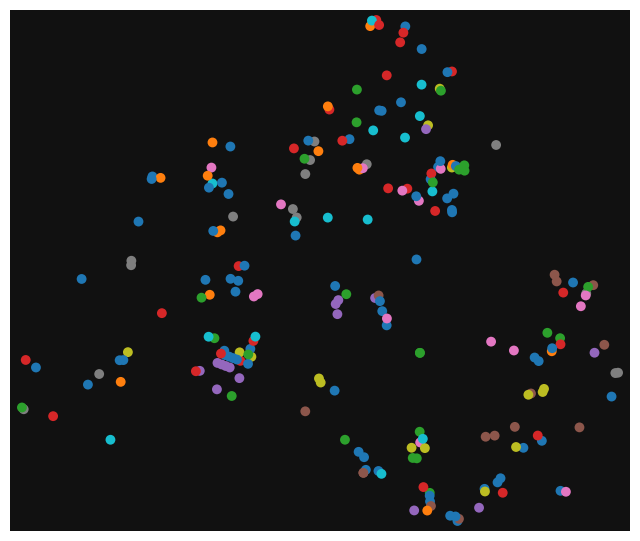

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [310]:
ox.plot_graph(G_filtered, node_color=node_color, node_size=50, edge_linewidth=0.5)